In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from analysis_funcs import *
from external_flux import *

In [3]:
import glob
import re

In [4]:
getobmt = lambda x: int(re.search("(?<=OBMT_START_)[0-9]+",x).group(0))

In [5]:
# get all paths
allpaths = glob.glob("../output/*/*/*/SM-SIF_OBMT_START_*.fits")
allpaths.sort(key = getobmt)

In [6]:
pathtimes_rev = np.array([getobmt(p) for p in allpaths])/(1e9*3600*6)

def psel_rev(start,stop):
    indices = np.where(np.logical_and(pathtimes_rev>=start, pathtimes_rev<=stop))[0]
    return [allpaths[ii] for ii in indices]


pathtimes_mjd = OBMT_apyTime(np.array([getobmt(p) for p in allpaths])).mjd

def psel_mjd(start,stop):
    indices = np.where(np.logical_and(pathtimes_mjd>=start, pathtimes_mjd<=stop))[0]
    return [allpaths[ii] for ii in indices]

In [7]:
len(allpaths)

1018

In [8]:
(t_P,f_P,err_P) = PPE_flux('../datasets/PPE/ASD4_Counters_FOV1_ROW1.dat')

In [9]:
(t_S,n_S,f_S,err_S) = fits_flux(allpaths)

In [10]:
t_goes, f_goes = read_flux_external(sorted(glob.glob('../datasets/external/GOES/GOES_20*.txt')))
t_goes = t_goes.mjd

#t_ace, f_ace = read_flux_external(sorted(glob.glob('../datasets/external/ACE/ACE_20*.txt')))
#t_ace = t_ace.mjd

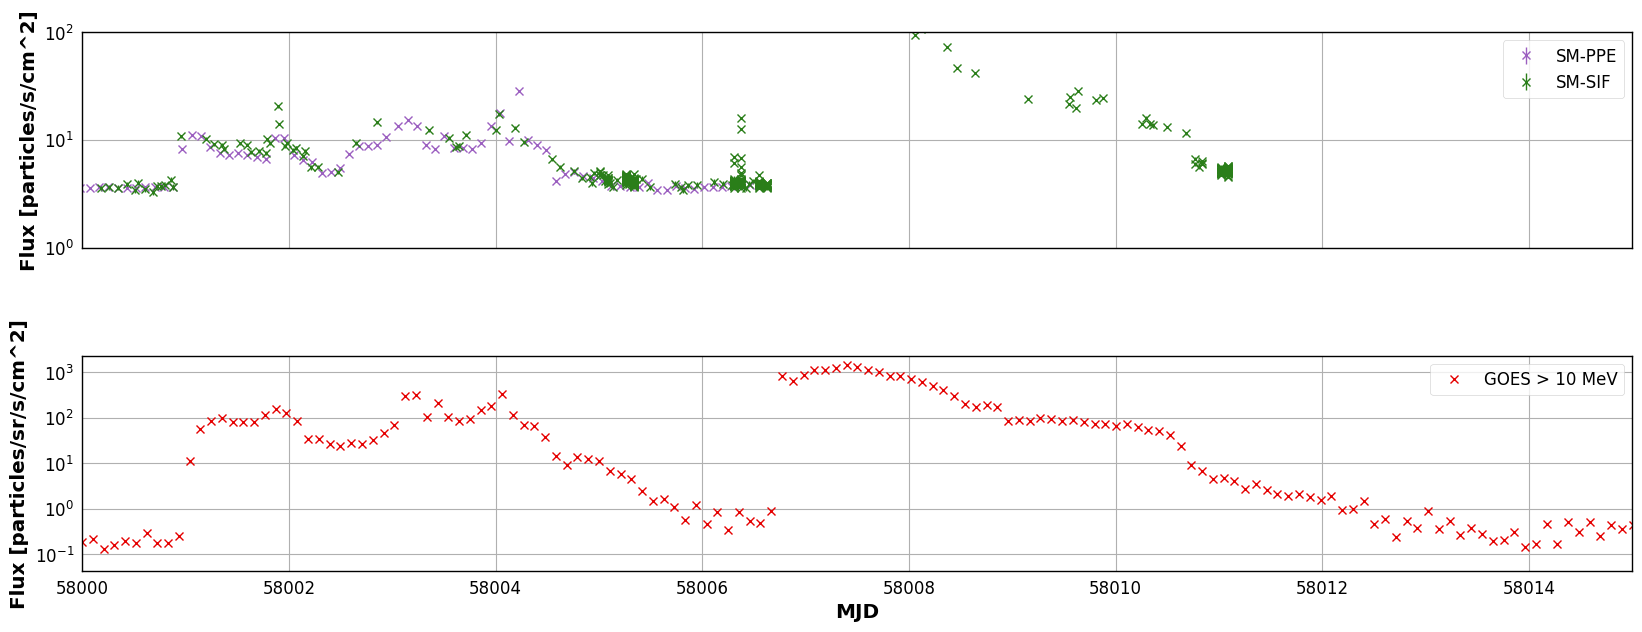

In [34]:
fig, (axint, axext) = plt.subplots(nrows=2,sharex=True)

axint.errorbar(OBMT_apyTime(t_P).mjd[::30], f_P[::30], yerr=err_P[::30], linestyle='', marker='x', color='xkcd:amethyst', label="SM-PPE")
axint.errorbar(OBMT_apyTime(t_S).mjd, f_S, yerr=err_S, linestyle='', marker='x', color='xkcd:tree green', label="SM-SIF")
axint.set_yscale('log')

axext.plot(t_goes[::30], f_goes[2][::30], linestyle='', marker='x', color='xkcd:red', label="GOES > 10 MeV")
#axext.plot(t_ace[::30], f_ace[1][::30], linestyle='', marker='x', color='xkcd:faded blue', label="ACE > 30 MeV")
axext.set_yscale('log')

axint.legend(loc='upper right')
axext.legend(loc='upper right')

axint.set_ylim(1,100)
axint.set_ylabel("Flux [particles/s/cm^2]")

#axext.set_ylim(.05,100)
axext.set_ylabel("Flux [particles/sr/s/cm^2]")
axext.set_xlabel("MJD")

axint.set_xlim(58000,58015) # Sept '17 Flare
#axint.set_xlim(57945,57955)  # Jul '17 Flare
#axint.set_xlim(56901,56915) # Sept '14
#axint.set_xlim(56880,57050)
#axint.set_xlim(56700,56730)


plt.gcf().set_size_inches(20,7)


In [15]:
testE = fits_energies_edgeless(psel_mjd(57500,57550))

In [41]:
#testE2 = fits_energies_edgeless(psel_mjd(56715,56720))
testE2 = fits_energies_edgeless(psel_mjd(58006,58012))

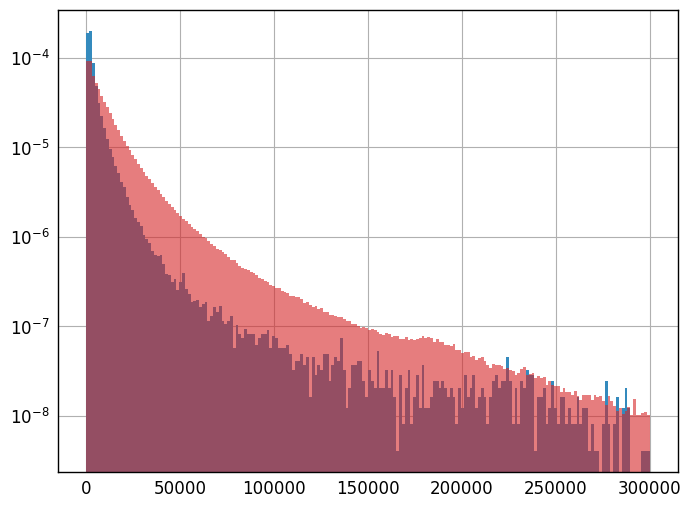

In [225]:
h1 = plt.hist(concatenate_energies(testE[1], range(len(testE[1]))), 200, range=(0,300000), normed=True, log=True)
h2 = plt.hist(concatenate_energies(testE2[1], range(len(testE2[1]))),200, range=(0,300000),normed=True, log=True,
                 color="tab:red", alpha=0.6)

Interesting very high energy behaviour, some sort of bump

Test: Instead of normalizing by the total number of particles, normalize by the geometry factors

In [74]:
def fits_geofacs(filenames):
    """
    Extract geometry factors from a list of fits files
    Returns an array of geometry factors [cm^2 s]
    """
    # Create lists for OBMT and fluxes
    facs = []
    
    # iterate over files
    for filename in filenames:
        # Open the file
        hdulist = fits.open(filename)

        # Iterate over all the track-observations
        for ii in range(1,len(hdulist),1):
            head = hdulist[ii].header        

            maskpix = head["MASKPIX"]
            srcAL = head["SRC_AL"]
            srcAC = head["SRC_AC"]

            source = head["SOURCE"]
            # this bit could be put outside the loop if we are SURE that a fits file only has one source
            # I think it should, but this should be fairly quick anyhow
            if source in ["BAM-OBS","BAM-SIF"]:
                # 1 x 4 binning
                pixAL = 10e-4
                pixAC = 120e-4
                exptime = 4.5 * 0.9828 + 19
            elif source == "SM-SIF":
                # 2 x 2 binning
                pixAL = 20e-4
                pixAC = 60e-4
                exptime = 2.9 * 0.9828

            exparea = pixAL*pixAC*(srcAL*srcAC - maskpix)
            
            
            facs.append(exparea*exptime)

        # Close the file
        hdulist.close()
    
    # Convert output to arrays and return
    facs = np.array(facs,dtype=float)
    
    return facs

In [77]:
gfacs1 = fits_geofacs(psel_mjd(57500,57550))
gfacs2 = fits_geofacs(psel_mjd(58006,58012))

In [176]:
def energy_hist_normed(obs_en, obs_gfacs, bins=None, enrange=None):
    """
    Given a list of energy arrays and a list of the geometry factors of the corresponding observations,
    Make a normed energy histogram - each observation is normed by its geometry factor and then averaged over
    The output histogram is counts/cm^2/s/eV
    """
    nobs = len(obs_gfacs)
    Eflat = concatenate_energies(obs_en, range(nobs))
    normflat = np.empty(len(Eflat))
    
    # determine the weights
    start = 0
    for ii in range(len(obs_gfacs)):
        normflat[start:start+len(obs_en[ii])] = 1/obs_gfacs[ii]
        start += +len(obs_en[ii])
    
    normflat /= nobs
    # compute the weighted histogram
    histout = np.histogram(Eflat,bins=bins,range=enrange, weights=normflat)
    
    # divide by bin size
    step = histout[1][1] - histout[1][0]
    #step=1
    
    return histout[0]/step, histout[1]

In [230]:
nhist1 = energy_hist_normed(testE[1],gfacs1,200,(0,300000))
nhist2 = energy_hist_normed(testE2[1][100:200],gfacs2[100:200],200,(0,300000))

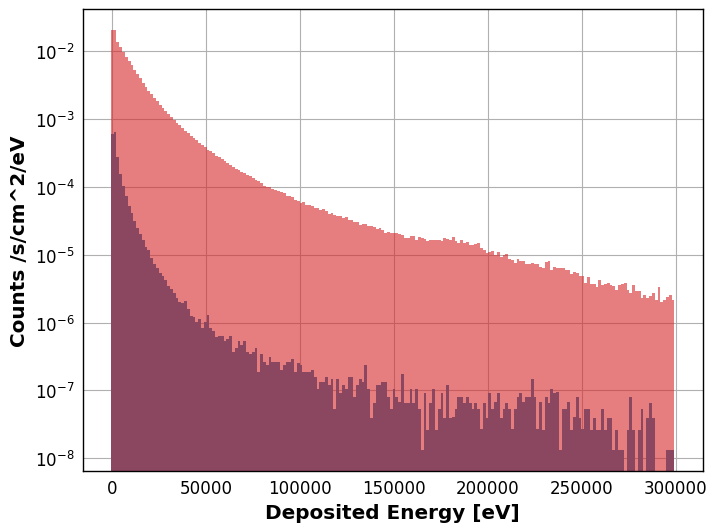

In [231]:
plt.bar(nhist1[1][:len(nhist1[0])], nhist1[0], nhist1[1][1]-nhist1[1][0], color="tab:blue")
plt.bar(nhist2[1][:len(nhist2[0])], nhist2[0], nhist2[1][1]-nhist2[1][0], color="tab:red",alpha=0.6)

plt.xlabel("Deposited Energy [eV]")
plt.ylabel("Counts /s/cm^2/eV")

plt.yscale('log')

In [224]:
np.sum(nhist1[0])*(nhist1[1][1]-nhist1[1][0])

3.2393451293840614